In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

import shap

import pickle

## 1- IMPORT DATA

In [2]:
#On recupère le dataframe mergé (voir kernel Kaggle)
df = pd.read_feather("data_feather.pkl")

## 2- TRAIN TEST SPLIT

In [3]:
# On recupère les données avec une target
train = df[df["TARGET"].notnull()]

X_train = train.drop(["TARGET", "SK_ID_CURR"], axis = 1)
y_train = train["TARGET"]

In [4]:
#On recupère le nombre de valeurs nulles
X_train_na = X_train.isna().sum()

#On recupère les variables avec plus de 90% de valeur non nulles
X_train_na_60 = list(X_train_na[(X_train_na*100/X_train.shape[0]) > 10].index)

#On supprime les variables ayant plus de 60% de valeurs nulles
X_train.drop(columns=X_train_na_60, inplace=True)

In [5]:
%%time

#On remplace les valeurs nan restantes par 0
X_train.replace({np.nan : 0}, inplace= True)

Wall time: 954 ms


In [6]:
%%time

#On remplace les valeurs inf par la valeur max et les valeurs -inf par la valeur min
for c in X_train.columns:
    if X_train[c].isin([-np.inf, np.inf]).any():
        print(c)
        max_value = max(list(X_train[~(X_train[c].isin([-np.inf, np.inf, np.nan]))][c]))
        min_value = min(list(X_train[~(X_train[c].isin([-np.inf, np.inf, np.nan]))][c]))
    
        X_train[c].replace({np.inf : max_value, -np.inf : min_value}, inplace= True)

INS_DAYS_INSTALMENT_SUM
INS_DAYS_ENTRY_PAYMENT_SUM
INS_PAYMENT_PERC_MAX
INS_PAYMENT_PERC_MEAN
INS_PAYMENT_PERC_SUM
INS_PAYMENT_PERC_MEDIAN
PREV_APP_CREDIT_PERC_MAX
PREV_APP_CREDIT_PERC_MEAN
Wall time: 13.3 s


## 3- Gestion du déséquilibre des données (SMOTE)

<BarContainer object of 2 artists>

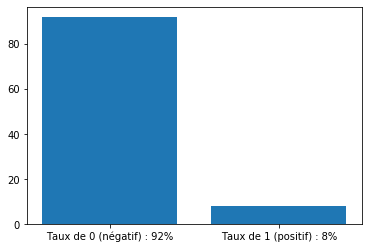

In [7]:
#On affiche la distribution de nos données cible (on observe un déséquilibre)
taux_0 = Counter(y_train)[0]*100/len(y_train)
taux_1 = Counter(y_train)[1]*100/len(y_train)

plt.bar(["Taux de 0 (négatif) : " + str(round(taux_0)) + "%"
         ,"Taux de 1 (positif) : " + str(round(taux_1))+ "%"]
        , [taux_0,taux_1])

In [8]:
#On affiche le nombre de clients par classe
Counter(y_train)

Counter({1.0: 24825, 0.0: 282680})

In [9]:
%%time
# Choix de la taille du nouveau dataset 
count_0 = Counter(y_train)[0]
distribution_of_samples = {0:count_0 , 1:50000}

# Sur-Echantillonnage en utilisant la méthode SMOTE
smote = SMOTE(sampling_strategy = distribution_of_samples, random_state=666)
X_under_tr, y_under_tr = smote.fit_resample(X_train, y_train)

Wall time: 26.3 s


In [10]:
%%time
# Choix de la taille du nouveau dataset 
distribution_of_samples = {0:50000, 1:50000}

# Sous-Echantillonnage en utilisant la méthode NearMiss
smote = NearMiss(sampling_strategy = distribution_of_samples)
X_over_tr, y_over_tr = smote.fit_resample(X_under_tr, y_under_tr)

Wall time: 8min


In [11]:
#On affiche le nouveau nombre de clients par classe
Counter(y_over_tr)

Counter({0.0: 50000, 1.0: 50000})

<BarContainer object of 2 artists>

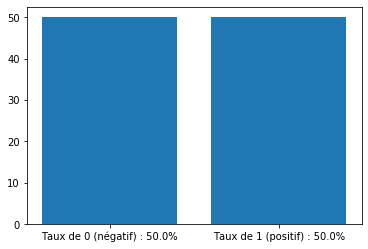

In [12]:
#On affiche la distribution de nos données cible (on observe un déséquilibre)
taux_0 = Counter(y_over_tr)[0]*100/len(y_over_tr)
taux_1 = Counter(y_over_tr)[1]*100/len(y_over_tr)

plt.bar(["Taux de 0 (négatif) : " + str(round(taux_0,1)) + "%"
         ,"Taux de 1 (positif) : " + str(round(taux_1,1))+ "%"]
        , [taux_0,taux_1])

In [13]:
#On effectue un train test pour entrainer et tester notre modèle
X_tr, X_val, y_tr, y_val = train_test_split(X_over_tr, y_over_tr, stratify=y_over_tr
                                                                , train_size=0.8, random_state=666)

## 4- XGBoost avec SMOTE

In [14]:
%%time

cls = xgb.XGBClassifier(use_label_encoder=False)
#                         , scale_pos_weight=Counter(y_over_tr)[0]/Counter(y_over_tr)[1])
# cls.set_params()
# scaler = StandardScaler()
# X_tr_scale = scaler.fit_transform(X_over_tr)
cls.fit(X_tr, y_tr)

[03:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1min 49s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [15]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import StratifiedKFold

In [16]:
# params = {'n_estimators': [100, 150]}

In [17]:
# %%time
# folds = 3
# param_comb = 2

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(cls, param_distributions=params, n_iter=param_comb
#                                    , scoring='f1', n_jobs=4, cv=skf.split(X_over_tr, y_over_tr)
#                                    , verbose=3, random_state=1001)

# random_search.fit(X_over_tr, y_over_tr)

In [18]:
# random_search.best_estimator_

In [19]:
#On affiche l'accuracy des données test
y_pred_xgb = cls.predict_proba(X_val)[:, 1]
[fpr_xgb, tpr_xgb, thr_xgb] = roc_curve(y_val, y_pred_xgb)

auc_xgb = auc(fpr_xgb, tpr_xgb)
print("Accuracy XGBoost : ", auc_xgb)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Accuracy XGBoost :  0.9601253599999999


In [20]:
#On affiche l'accuracy des données train (surapprentissage)
y_pred_xgb_tr = cls.predict_proba(X_tr)[:, 1]
[fpr_xgb_tr, tpr_xgb_tr, thr_xgb_tr] = roc_curve(y_tr, y_pred_xgb_tr)

auc_xgb_tr = auc(fpr_xgb_tr, tpr_xgb_tr)
print("Accuracy XGBoost Xtrain : ", auc_xgb_tr)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Accuracy XGBoost Xtrain :  0.9873445356249999


Text(0, 0.5, 'Sensibilite')

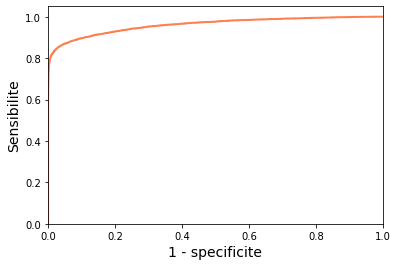

In [21]:
#On affiche notre courbe ROC
plt.plot(fpr_xgb, tpr_xgb, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

## 5- Matrice de confusion et indicateurs clés

In [22]:
#On compte les valeurs réelles
print("Valeurs réelles : ", Counter(y_val))

#On fixe 0.5 comme seuil par défaut
seuil = 0.5
y_pred_xgb_0_1 = [0 if x < seuil else 1 for x in y_pred_xgb]
print("Valeurs prédites : ", Counter(y_pred_xgb_0_1))

Valeurs réelles :  Counter({0.0: 10000, 1.0: 10000})
Valeurs prédites :  Counter({0: 10875, 1: 9125})


In [23]:
#On affiche nos fonctions coût
print("Accuracy : ", round(accuracy_score(y_val, y_pred_xgb_0_1), 2))
print("Precision : ",round(precision_score(y_val, y_pred_xgb_0_1), 2))
print("Sensibility : ", round(recall_score(y_val, y_pred_xgb_0_1), 2))
print("F1 Score : ",round(f1_score(y_val, y_pred_xgb_0_1), 2))
print("MCC : ",round(matthews_corrcoef(y_val, y_pred_xgb_0_1), 2))


Accuracy :  0.91
Precision :  0.95
Sensibility :  0.87
F1 Score :  0.91
MCC :  0.82


In [24]:
#On calcule l'ensemble de nos fonctions coût pour différents seuil allant de 0 à 1
precision_tab = []
sensibility_tab = []
f1_score_tab = []
matthews_corrcoef_tab = []

rang = np.linspace(0.01,1,5)

for seuil in rang:
    y_pred_xgb_0_1 = []
    y_pred_xgb_0_1 = [0 if x < seuil else 1 for x in y_pred_xgb]
    precision_tab.append(round(precision_score(y_val, y_pred_xgb_0_1), 2))
    sensibility_tab.append(round(recall_score(y_val, y_pred_xgb_0_1), 2))
    f1_score_tab.append(round(f1_score(y_val, y_pred_xgb_0_1), 2))
    matthews_corrcoef_tab.append(round(matthews_corrcoef(y_val, y_pred_xgb_0_1), 2))

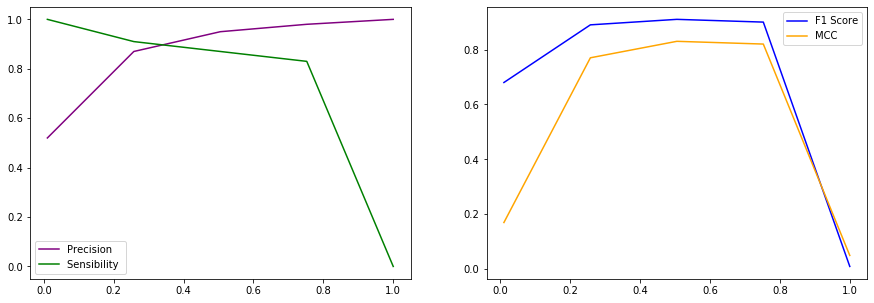

In [25]:
#On affiche les valeurs de nos fonctions coût pour différents seuil allant de 0 à 1
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1)
plt.plot(rang, precision_tab, color='purple', label='Precision')
plt.plot(rang, sensibility_tab, color='green', label='Sensibility ')
ax.legend()

ax = fig.add_subplot(1,2,2)
plt.plot(rang, f1_score_tab, color='blue', label='F1 Score')
plt.plot(rang, matthews_corrcoef_tab, color='orange', label='MCC')
ax.legend()

In [26]:
#On compte les valeurs réelles
print("Valeurs réelles : ", Counter(y_val))

#On fixe le seuil à 0.3 (le plus intéressant pour notre problème)
seuil = 0.8
y_pred_xgb_0_1 = [0 if x < seuil else 1 for x in y_pred_xgb]
print("Valeurs prédites : ", Counter(y_pred_xgb_0_1))

Valeurs réelles :  Counter({0.0: 10000, 1.0: 10000})
Valeurs prédites :  Counter({0: 11722, 1: 8278})


In [27]:
print("Accuracy : ", round(accuracy_score(y_val, y_pred_xgb_0_1), 2))
print("Precision : ",round(precision_score(y_val, y_pred_xgb_0_1), 2))
print("Sensibility : ", round(recall_score(y_val, y_pred_xgb_0_1), 2))
print("F1 Score : ",round(f1_score(y_val, y_pred_xgb_0_1), 2))
print("MCC : ",round(matthews_corrcoef(y_val, y_pred_xgb_0_1), 2))

Accuracy :  0.9
Precision :  0.99
Sensibility :  0.82
F1 Score :  0.89
MCC :  0.82


In [28]:
pd.crosstab(y_val, np.array(y_pred_xgb_0_1), rownames=['True']
            , colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0.0,9894,106,10000
1.0,1828,8172,10000
All,11722,8278,20000


In [29]:
pd.crosstab(y_val, np.array(y_pred_xgb_0_1), rownames=['True']
            , colnames=['Predicted'], margins=True).apply(lambda r: round(r/y_val.count()*100,1), axis=1)

Predicted,0,1,All
True,,,
0.0,49.5,0.5,50.0
1.0,9.1,40.9,50.0
All,58.6,41.4,100.0


- La précision est la probabilité que le test soit positif si la client est un bon client
- La sensibilité est la probabilité que le test soit positif si la client est un mauvais client

In [30]:
#On sauvegarde notre modèle au format pickle
with open("best_model_XGBoost_pickle.pkl", 'wb') as file:  
    pickle.dump(cls, file)

## 6- Comprehension du modèle

In [31]:
#On importe le modèle shap pour l'interprétabilité de notre modèle
shap.initjs()

explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_over_tr)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


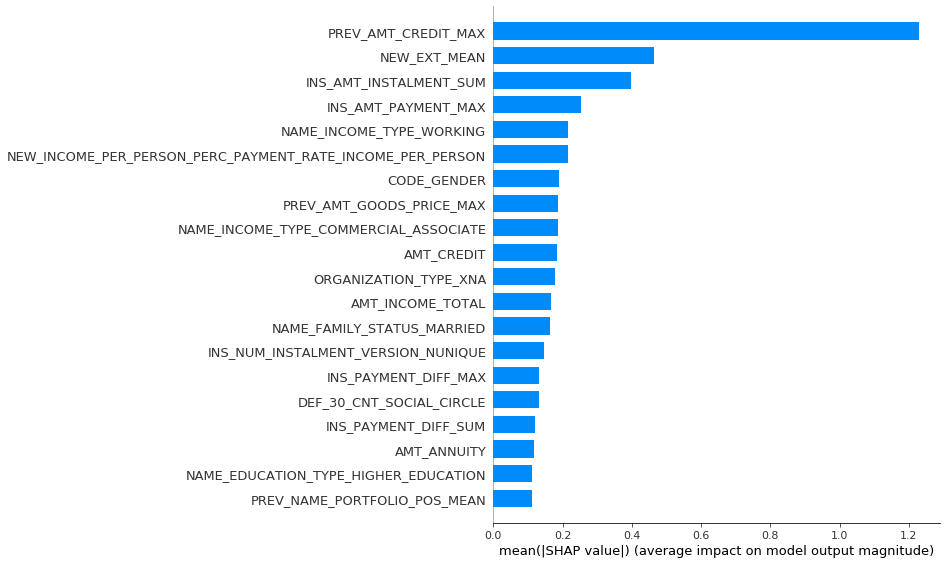

In [32]:
#On trace l'importance des variables de notre modèle
fig = shap.summary_plot(shap_values, X_over_tr, plot_type="bar")

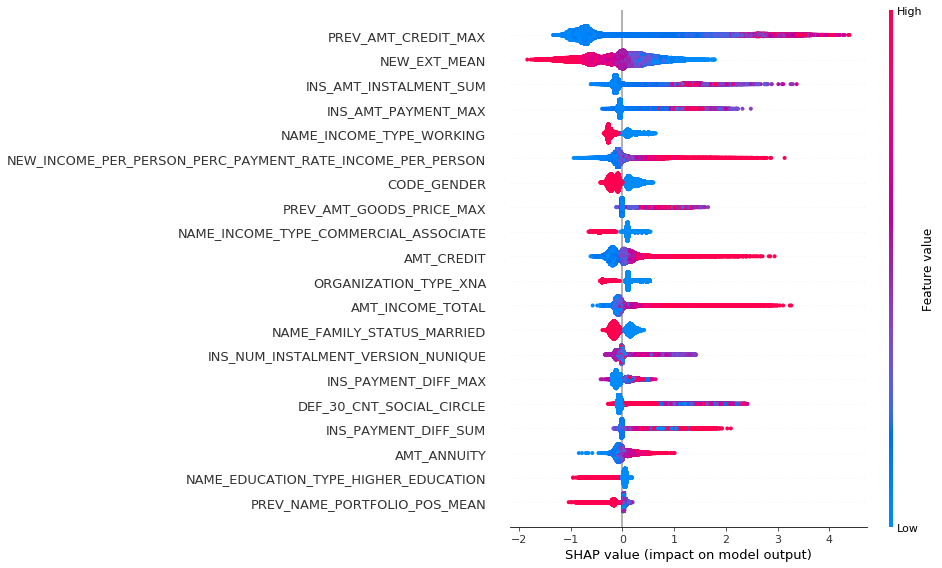

In [33]:
#On affiche l'ensemble des clients en fonction de l'importance de nos variables
shap.summary_plot(shap_values, X_over_tr)

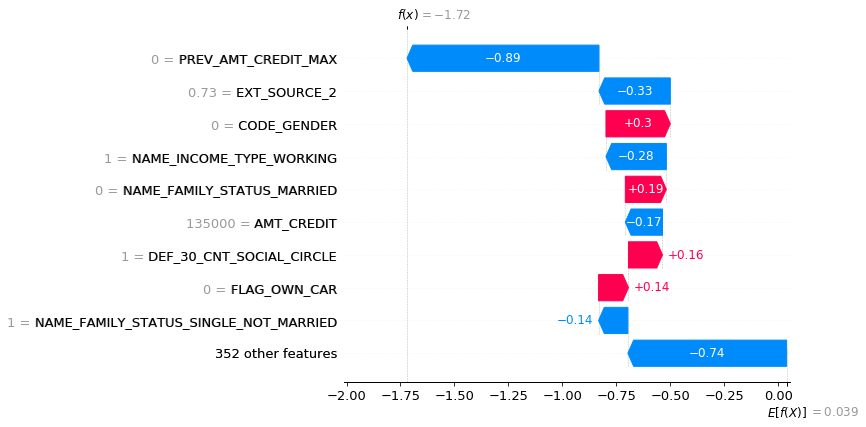

In [34]:
#On trace le waterfall d'un client eligible
shap.waterfall_plot(shap.Explanation(values=shap_values[2,:],
                                     base_values=explainer.expected_value,
                                     data=X_over_tr.iloc[2,:],
                                     feature_names=X_over_tr.columns.tolist()),max_display=10)

## 7- Création du dataframe pour le dashboard interactif

In [35]:
#On prépare le dataframe n'ayant pas de target
test = df[df["TARGET"].isnull()]
X_test = test.drop(["TARGET"], axis = 1)

del df

In [36]:
#On supprime les variables ayant plus de 10% de valeurs nulles
X_test.drop(columns=X_train_na_60, inplace=True)

In [37]:
%%time

#On remplace les valeurs nan restantes par 0
X_test.replace({np.nan : 0}, inplace= True)

Wall time: 100 ms


In [38]:
%%time

#On remplace les valeurs inf par la valeur max et les valeurs -inf par la valeur min
for c in X_test.columns:
    if X_test[c].isin([-np.inf, np.inf]).any():
        print(c)
        max_value = max(list(X_test[~(X_test[c].isin([-np.inf, np.inf, np.nan]))][c]))
        min_value = min(list(X_test[~(X_test[c].isin([-np.inf, np.inf, np.nan]))][c]))
    
        X_test[c].replace({np.inf : max_value, -np.inf : min_value}, inplace= True)

INS_DAYS_INSTALMENT_SUM
INS_DAYS_ENTRY_PAYMENT_SUM
INS_PAYMENT_PERC_MAX
INS_PAYMENT_PERC_MEAN
INS_PAYMENT_PERC_SUM
Wall time: 1.32 s


In [39]:
#On recupère le score et la valeur binaire definissant si le client est eligible ou non
target = cls.predict(X_test.iloc[:,1:])
score = [round(i,2) for i in cls.predict_proba(X_test.iloc[:,1:])[:, 1]]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [40]:
#On affiche le nombre de clients par classe
Counter(target)

Counter({0: 12509, 1: 36235})

In [41]:
#On ajoute la target et le score à notre dataframe
X_test['SCORE'] = score
X_test['TARGET'] = target
X_test.reset_index(drop=True, inplace=True)

In [42]:
#On sauvegarde le dataframe au format pickle
with open("data_customers.pkl", 'wb') as file:  
    pickle.dump(X_test, file)